In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from PIL import Image
from skimage import data
import scipy
import math
from scipy.ndimage import measurements
from skimage import data
from ipywidgets import interact, fixed, FloatSlider, IntSlider,FloatRangeSlider, Label

In [2]:
from scipy.ndimage import convolve
plt.rcParams['image.interpolation'] = 'none'
def convolve(kernel,original_image):
    # Normalize the kernel
    kernel_sum=abs(np.sum(kernel))
    kernel= kernel/kernel_sum if kernel_sum else kernel
    filtered_image = scipy.ndimage.convolve(original_image, kernel)
    return filtered_image

In [3]:
# A gaussian filter helps us reduce noise in the image
def gaussian_filter(size=7, sigma=5.0):
    gaussian_filter.filtered_image = cv2.GaussianBlur(cameraman_image,(size,size), sigma, sigma)
    fig1, axes_array = plt.subplots(1, 2)
    fig1.set_size_inches(8,4)
    image_plot = axes_array[0].imshow(cameraman_image,cmap=plt.cm.gray) 
    axes_array[0].axis('off')
    axes_array[0].set(title='Original Image')
    image_plot = axes_array[1].imshow(gaussian_filter.filtered_image,cmap=plt.cm.gray)
    axes_array[1].axis('off')
    axes_array[1].set(title='Filtered Image')
    plt.show()    

cameraman_image = data.camera()/255.
interact(gaussian_filter,size=IntSlider(min=1., max=11., step=2, value=7),
         sigma=FloatSlider(min=0.1, max=10, step=0.1, value=5.0));


interactive(children=(IntSlider(value=7, description='size', max=11, min=1, step=2), FloatSlider(value=5.0, de…

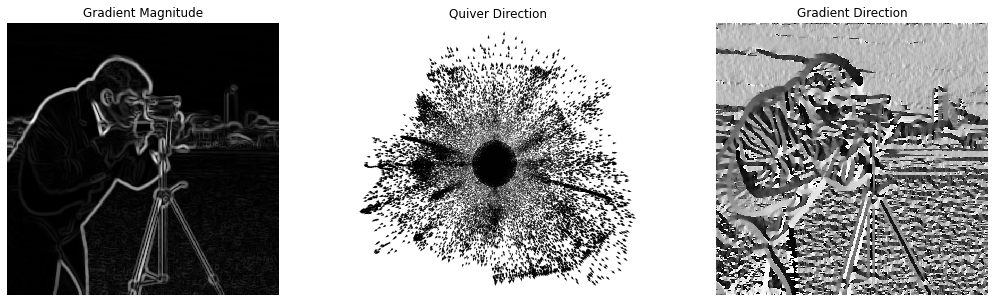

In [4]:
from skimage.color import rgb2gray
filtered_img = gaussian_filter.filtered_image
#plt.imshow(filtered_img, cmap=plt.cm.gray);

def sobel_operation():
    Sx = np.array([[-1., 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Sy = np.array([[1., 2, 1], [0, 0, 0], [-1, -2, -1]])
    kernel_sum = abs(np.sum(Sx))
    Sx = Sx / kernel_sum if kernel_sum else Sx
    kernel_sum = abs(np.sum(Sy))
    Sy = Sy / kernel_sum if kernel_sum else Sy
    Gx = convolve(Sx, filtered_img)
    Gy = convolve(Sy, filtered_img )
    Gm = np.sqrt(Gx**2+Gy**2)
    Gd = np.arctan2(Gy, Gx)
    Vx = Gm * np.cos(Gd)
    Vy = Gm * np.sin(Gd)
    fig2, axes_array = plt.subplots(1, 3)
    fig2.set_size_inches(18,5)
    image_plot = axes_array[0].imshow(Gm, cmap=plt.cm.gray)  
    axes_array[0].axis('off')
    axes_array[0].set(title='Gradient Magnitude')
    image_plot = axes_array[1].quiver(Gx, Gy, Vx, Vy)
    axes_array[1].axis('off')
    axes_array[1].set(title='Quiver Direction')
    image_plot = axes_array[2].imshow(Gd, cmap=plt.cm.gray)  
    axes_array[2].axis('off')
    axes_array[2].set(title='Gradient Direction')
    plt.show()
    return Gx, Gy, Gm, Gd
    
vertical_edge_img, horizontal_edge_img, gradient_magnitude, gradient_direction = sobel_operation()


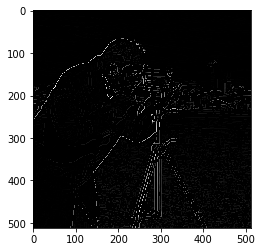

In [5]:
def non_max_supress(Gm, Gd, threshold):
    non_max_supress.local_maximum_img = np.zeros(Gm.shape, Gm.dtype) 
    Gd = Gd *(180.0 / np.pi)
    magnitude_row, magnitude_column = Gm.shape
    for column in range(1, magnitude_column-1):
        for row in range(1, magnitude_row-1):
            magnitude = Gm[row, column]
            if magnitude < threshold:
                continue
            angle = Gd[row, column]
            if angle >= -22.5 and angle <= 22.5:
                dx, dy = 1, 0 
            elif angle > 22.5 and angle < 67.5:
                dx, dy = 1, 1 
            elif angle >= 67.5 and angle <= 112.5:
                dx, dy = 0, 1 
            elif angle > 112.5 and angle < 157.5:
                dx, dy = 1, 1
            elif angle >= -67.5 and angle <-22.5:
                dx, dy = 1, 1
            elif angle >= -112.5 and angle <= -67.5:
                dx, dy = 0, 1
            elif angle > -157.5 and angle < -112.5:
                dx, dy = 1, 1
            elif angle >= 157.5 and angle <= -157.5:
                dx, dy = 1, 0
            if magnitude > Gm[row+dy, column+dx] and magnitude > Gm[row-dy, column-dx]:
                non_max_supress.local_maximum_img[row, column] = magnitude
    plt.imshow(non_max_supress.local_maximum_img, cmap=plt.cm.gray)

non_max_supress(gradient_magnitude, gradient_direction, -0.01)

In [6]:
def double_thresholding(threshold_range=[1.0,2.0]):
    edge = np.zeros(non_max_supress.local_maximum_img.shape)
    edge[np.where(non_max_supress.local_maximum_img > (threshold_range[1])/10)] = 1
    edge[np.where((non_max_supress.local_maximum_img < (threshold_range[1]/10)) & (non_max_supress.local_maximum_img > (threshold_range[0]/10)))] = 0.5
    for x in range(1, non_max_supress.local_maximum_img.shape[0]-2):
        for y in range(1,  non_max_supress.local_maximum_img.shape[1]-2):
            if edge[x, y] == 0.5:
                if (edge[x+1, y] == 1 or edge[x-1, y] == 1 or edge[x, y+1] == 1 or edge[x, y-1] == 1 or
                            edge[x+1, y+1] == 1 or edge[x+1, y-1] == 1 or edge[x-1, y+1] == 1 or edge[x-1, y-1] == 1):
                    edge[x, y] = 1
                else:
                    edge[x, y] = 0
            else:
                continue
    plt.imshow(edge, cmap=plt.cm.binary)

interact(double_thresholding,threshold_range=FloatRangeSlider(min=0.0, max=10, step=1,value=[1,2]));

interactive(children=(FloatRangeSlider(value=(1.0, 2.0), description='threshold_range', max=10.0, step=1.0), O…